In [1]:
## ref : https://www.kaggle.com/mgabrielkerr/visualizing-knn-svm-and-xgboost-on-iris-dataset

In [2]:
# Import data and modules
import pandas as pd
import numpy as np
from sklearn import datasets
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

iris = datasets.load_iris()

# We'll use the petal length and width only for this analysis
X = iris.data[:, [2, 3]]
y = iris.target

# Place the iris data into a pandas dataframe
iris_df = pd.DataFrame(iris.data[:, [2, 3]], columns=iris.feature_names[2:])

# View the first 5 rows of the data
print(iris_df.head())

# Print the unique labels of the dataset
print('\n' + 'The unique labels in this data are ' + str(np.unique(y)))

Populating the interactive namespace from numpy and matplotlib
   petal length (cm)  petal width (cm)
0                1.4               0.2
1                1.4               0.2
2                1.3               0.2
3                1.5               0.2
4                1.4               0.2

The unique labels in this data are [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

print('There are {} samples in the training set and {} samples in the test set'.format(
X_train.shape[0], X_test.shape[0]))
print()

There are 105 samples in the training set and 45 samples in the test set



In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('After standardizing our features, the first 5 rows of our data now look like this:\n')
print(pd.DataFrame(X_train_std, columns=iris_df.columns).head())

After standardizing our features, the first 5 rows of our data now look like this:

   petal length (cm)  petal width (cm)
0          -0.182950         -0.293181
1           0.930661          0.737246
2           1.042022          1.638870
3           0.652258          0.350836
4           1.097702          0.737246


In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

print('The accuracy of the knn classifier is {:.2f} out of 1 on training data'.format(knn.score(X_train_std, y_train)))
print('The accuracy of the knn classifier is {:.2f} out of 1 on test data'.format(knn.score(X_test_std, y_test)))

The accuracy of the knn classifier is 0.95 out of 1 on training data
The accuracy of the knn classifier is 1.00 out of 1 on test data


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


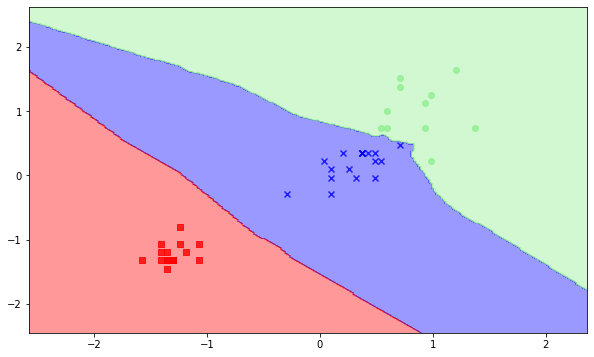

In [7]:
plot_decision_regions(X_test_std, y_test, knn)

### do it with Elasticsearch

In [8]:
# settings

mapping = {
    "properties" : {
        "my_vector" : {
            "type" : "knn_vector",
            "dimension" : 2
        },
        "actual_label" : {
            "type" : "integer"
        }
    }
}

settings = {
    "settings" : {
        "index" : {
            "knn" : True,
            "knn.space_type": "l2"
        }
    }
}

index = "iris"

In [9]:
# note : BE CAREFUL WHEN USING WITH CONFIDENTIAL INFORMATION
# disabling ca_certs and verify_verts mannually

from elasticsearch import Elasticsearch
es = Elasticsearch(
    "https://localhost:9200", 
    http_auth=("admin", "admin"), 
    ca_certs=False, 
    verify_certs=False
)

In [10]:
es.indices.create(index=index, body=settings)
es.indices.put_mapping(index=index, body=mapping)

{'acknowledged': True}

In [11]:
from elasticsearch import helpers

# actions to pass into elasticsearch
actions = []

for i, (x, y) in enumerate(zip(X_train_std, y_train)):
    doc = {"my_vector": x, "actual_label": y}
    actions.append({'_index': index, '_id': i, '_source':doc})
    
    if len(actions) > 10:
        helpers.bulk(es, actions)
        actions = []

helpers.bulk(es, actions)

# sleep 5 sec for waiting data being indexed
import time
time.sleep(5)

In [12]:
##test documents are indexed correctlly
es.search(index=index, body={"size": 2})

{'took': 5,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 105, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'iris',
    '_type': '_doc',
    '_id': '0',
    '_score': 1.0,
    '_source': {'my_vector': [-0.18295038753844117, -0.2931811407598559],
     'actual_label': 1}},
   {'_index': 'iris',
    '_type': '_doc',
    '_id': '1',
    '_score': 1.0,
    '_source': {'my_vector': [0.9306606670433726, 0.7372462995676713],
     'actual_label': 2}}]}}

In [13]:
neerest_label = []
for x in X_test_std:
    request = {
        "size": 1,
        "query": {
            "knn": {
                "my_vector": {
                    "vector": x,
                    "k": 1
                }
            }
        }
    }
    
    response = es.search(index=index, body=request)
    neerest_label.append(response.get('hits').get('hits')[0].get('_source').get('actual_label'))

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(neerest_label, y_test)

0.9555555555555556